In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def process_hr_data():
    # 1. Chargement des données
    print("Chargement des fichiers...")
    general_data = pd.read_csv('data/general_data.csv')
    manager_survey = pd.read_csv('data/manager_survey_data.csv')
    employee_survey = pd.read_csv('data/employee_survey_data.csv')
    in_time = pd.read_csv('data/in_time.csv')
    out_time = pd.read_csv('data/out_time.csv')
    # 2. Fusion des données principales
    # On utilise EmployeeID comme clé de jointure
    df_main = general_data.merge(manager_survey, on='EmployeeID', how='left')
    df_main = df_main.merge(employee_survey, on='EmployeeID', how='left')

    # 3. Traitement des fichiers Temps (Badgeuse)
    # Renommer la première colonne vide ou index en 'EmployeeID'
    in_time.rename(columns={in_time.columns[0]: 'EmployeeID'}, inplace=True)
    out_time.rename(columns={out_time.columns[0]: 'EmployeeID'}, inplace=True)

    # Définir l'index pour faciliter les calculs matriciels
    in_time.set_index('EmployeeID', inplace=True)
    out_time.set_index('EmployeeID', inplace=True)

    print("Traitement des horaires (conversion et calcul)...")
    # Conversion en datetime (ignorer les erreurs pour les jours fériés/absences)
    processed_in = in_time.apply(pd.to_datetime, errors='coerce')
    processed_out = out_time.apply(pd.to_datetime, errors='coerce')

    # Calcul de la durée de travail journalière
    duration = processed_out - processed_in
    # Conversion en heures
    duration_hours = duration.apply(lambda x: x.dt.total_seconds() / 3600)

    # Création des nouvelles métriques
    # Moyenne des heures travaillées par jour (en ignorant les NaN/absences)
    mean_hours = duration_hours.mean(axis=1)
    # Nombre total de jours travaillés dans l'année
    working_days = duration_hours.count(axis=1)

    # Création du DataFrame des features temporelles
    time_features = pd.DataFrame({
        'EmployeeID': in_time.index,
        'AverageWorkingHours': mean_hours.values,
        'TotalWorkingDays': working_days.values
    })

    # 4. Fusion finale
    final_df = df_main.merge(time_features, on='EmployeeID', how='left')

    # 5. Nettoyage
    # Suppression des colonnes qui n'ont qu'une seule valeur (inutiles pour le modèle)
    # Exemple: 'Over18' est 'Y' pour tout le monde, 'StandardHours' est 8 pour tout le monde.
    nunique = final_df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    final_df.drop(columns=cols_to_drop, inplace=True)

    print(f"Colonnes supprimées (valeur constante) : {list(cols_to_drop)}")
    print(f"Taille finale du dataset : {final_df.shape}")

    # 6. Export
    final_df.to_csv('processed_hr_data.csv', index=False)
    print("Fichier 'processed_hr_data.csv' généré avec succès.")

    return final_df

# Exécution
if __name__ == "__main__":
    df = process_hr_data()
    print(df.head())

Chargement des fichiers...
Traitement des horaires (conversion et calcul)...
Colonnes supprimées (valeur constante) : ['EmployeeCount', 'Over18', 'StandardHours']
Taille finale du dataset : (4410, 28)
Fichier 'processed_hr_data.csv' généré avec succès.
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeID  Gender  JobLevel  ... YearsAtCompany  \
0          2  Life Sciences           1  Female         1  ...              1   
1          1  Life Sciences           2  Female         1  ...              5   
2          4     

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Chargement des données
df = pd.read_csv('processed_hr_data.csv')

# 2. Nettoyage initial
if 'EmployeeID' in df.columns:
    df = df.drop(columns=['EmployeeID'])

# Remplissage des valeurs manquantes (uniquement sur les colonnes numériques)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# 3. Traitement de la cible (Target)
if 'Attrition' in df.columns:
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 4. Traitement des variables catégorielles

# A) Variable Ordinale (Ordre important) : BusinessTravel
# On map manuellement pour respecter la hiérarchie : Non < Rare < Frequent
travel_map = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
if 'BusinessTravel' in df.columns:
    df['BusinessTravel'] = df['BusinessTravel'].map(travel_map)

# B) Variables Nominales (Pas d'ordre) : One-Hot Encoding
# Cela va créer des colonnes comme 'Department_Sales', 'Department_HR', etc.
nominal_cols = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
# On vérifie que les colonnes existent bien
nominal_cols = [c for c in nominal_cols if c in df.columns]

# On applique le One-Hot Encoding (pd.get_dummies)
df_encoded = pd.get_dummies(df, columns=nominal_cols)
# On convertit tout en nombres (0.0 / 1.0) pour être sûr
df_encoded = df_encoded.astype(float)

# --- GÉNÉRATION DES DEUX FICHIERS ---

# FICHIER 1 : Non Normalisé (Brut mais encodé)
# Utile pour Random Forest, XGBoost, interprétation métier.
# Les salaires restent à 50000, l'âge à 30, etc.
df_not_normalized = df_encoded.copy()
df_not_normalized.to_csv('processed_hr_data_encoded_raw.csv', index=False)

# FICHIER 2 : Normalisé (0-1)
# Utile pour Réseaux de Neurones, KNN, Régression Logistique.
# Toutes les valeurs sont ramenées entre 0 et 1.
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
df_normalized.to_csv('processed_hr_data_encoded_normalized.csv', index=False)

print("Traitement terminé.")
print(f"Colonnes générées ({len(df_encoded.columns)}) :")
print(df_encoded.columns.tolist())

Traitement terminé.
Colonnes générées (45) :
['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'AverageWorkingHours', 'TotalWorkingDays', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executi

C:\Users\Fire\AppData\Local\Temp\ipykernel_6980\3538514816.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Attrition_Label', data=df, palette='viridis', order=['No', 'Yes'])


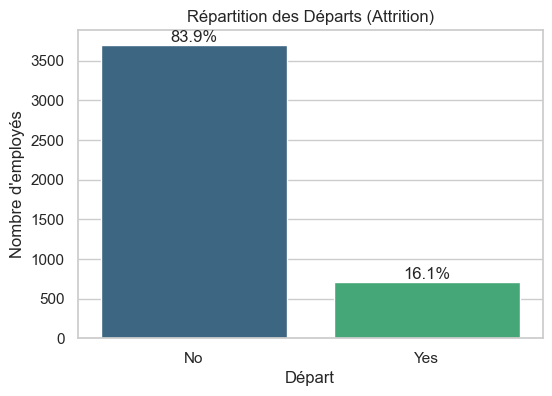

C:\Users\Fire\AppData\Local\Temp\ipykernel_6980\3538514816.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_attrition.index, y=role_attrition.values, palette='magma')


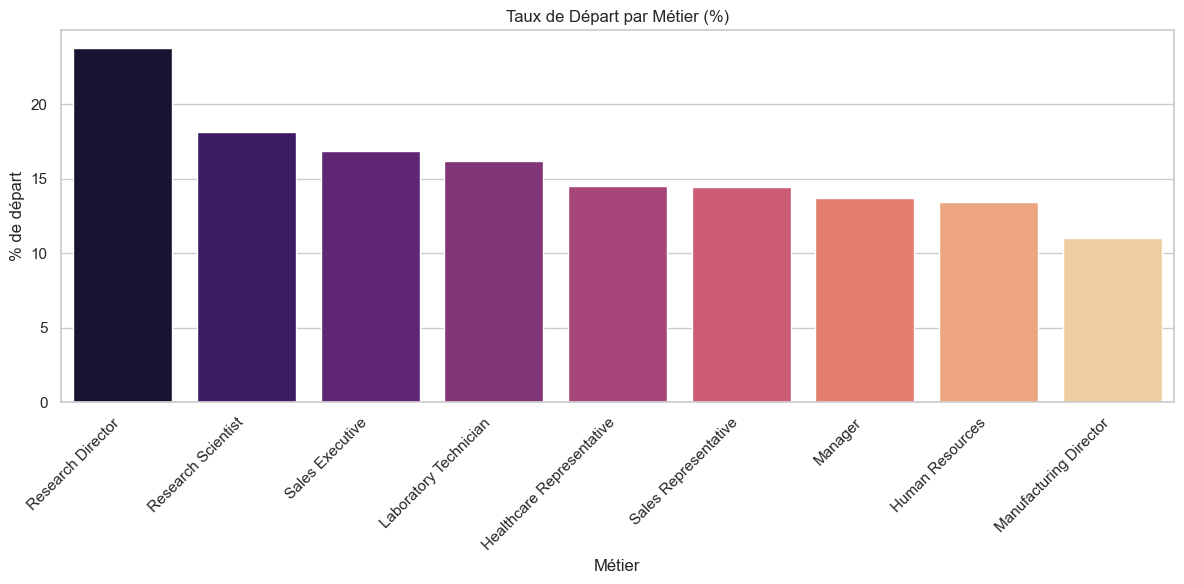

C:\Users\Fire\AppData\Local\Temp\ipykernel_6980\3538514816.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition_Label', y='AverageWorkingHours', data=df, palette='coolwarm', order=['No', 'Yes'])


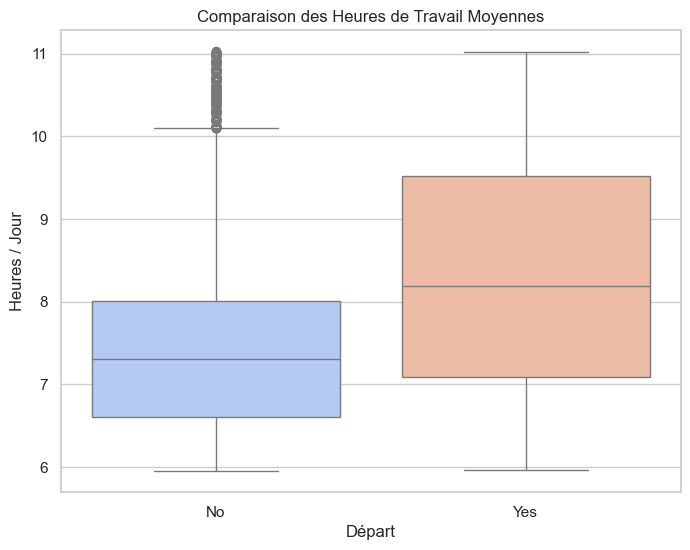

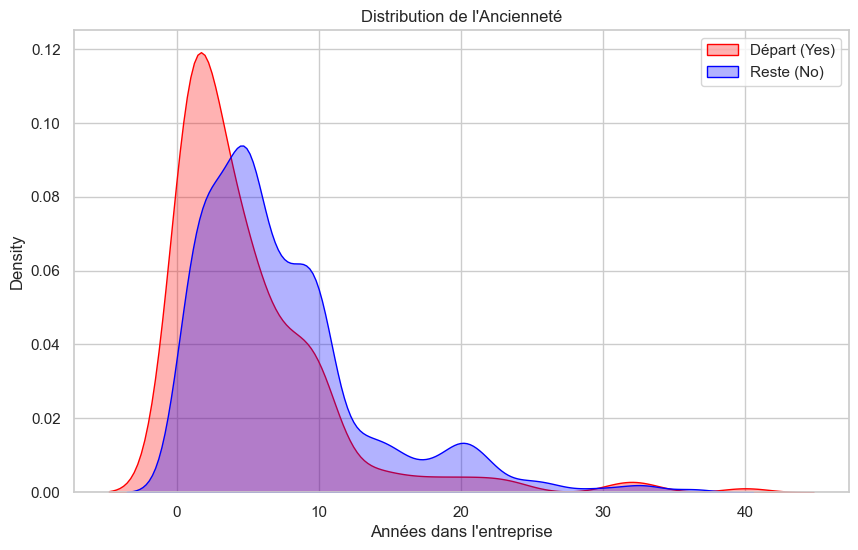

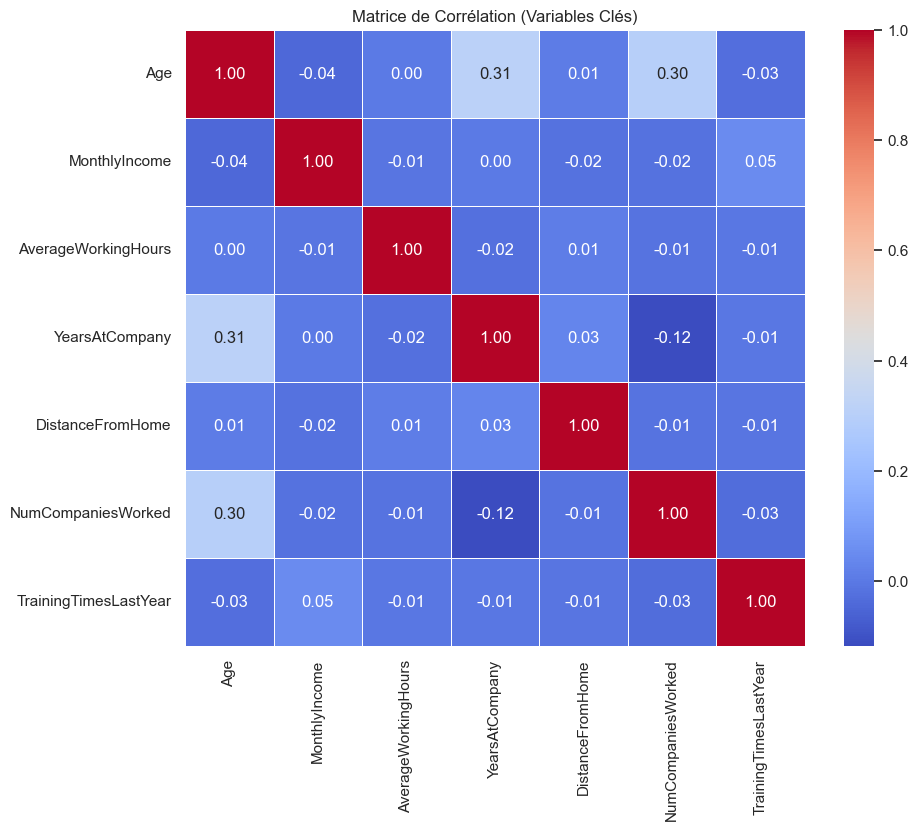

In [12]:
def analyze_and_show():
    # 1. Chargement des données encodées (mais non normalisées)
    df = pd.read_csv('processed_hr_data_encoded_raw.csv')
    
    # --- PRÉPARATION POUR L'AFFICHAGE ---
    # Pour que les graphiques soient lisibles, on recrée temporairement des labels
    
    # 1. On recrée une colonne "Attrition_Label" (0 -> No, 1 -> Yes)
    df['Attrition_Label'] = df['Attrition'].map({0: 'No', 1: 'Yes'})
    
    # 2. On reconstruit la colonne "JobRole" à partir des colonnes One-Hot (JobRole_Sales, etc.)
    # On prend toutes les colonnes qui commencent par 'JobRole_'
    job_role_cols = [c for c in df.columns if c.startswith('JobRole_')]
    # On trouve pour chaque ligne quelle colonne a la valeur 1
    # .idxmax() renvoie le nom de la colonne (ex: "JobRole_Manager")
    # .str.replace() enlève le préfixe pour avoir juste "Manager"
    df['JobRole_Reconstructed'] = df[job_role_cols].idxmax(axis=1).str.replace('JobRole_', '')

    # Configuration du style
    sns.set(style="whitegrid")
    
    # --- GRAPHIQUE 1 : Distribution Globale ---
    plt.figure(figsize=(6, 4))
    # On utilise la colonne Label pour avoir "Yes/No" sur le graphe
    ax = sns.countplot(x='Attrition_Label', data=df, palette='viridis', order=['No', 'Yes'])
    plt.title('Répartition des Départs (Attrition)')
    plt.xlabel('Départ')
    plt.ylabel('Nombre d\'employés')
    
    # Pourcentages
    total = len(df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    
    plt.show()

    # --- GRAPHIQUE 2 : Départ par Métier ---
    # On utilise la colonne JobRole reconstruite et la valeur numérique Attrition (0/1) pour la moyenne
    role_attrition = df.groupby('JobRole_Reconstructed')['Attrition'].mean() * 100
    role_attrition = role_attrition.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=role_attrition.index, y=role_attrition.values, palette='magma')
    plt.xticks(rotation=45, ha='right')
    plt.title('Taux de Départ par Métier (%)')
    plt.ylabel('% de départ')
    plt.xlabel('Métier')
    plt.tight_layout()
    plt.show()

    # --- GRAPHIQUE 3 : Heures de Travail ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Attrition_Label', y='AverageWorkingHours', data=df, palette='coolwarm', order=['No', 'Yes'])
    plt.title('Comparaison des Heures de Travail Moyennes')
    plt.ylabel('Heures / Jour')
    plt.xlabel('Départ')
    plt.show()

    # --- GRAPHIQUE 4 : Ancienneté ---
    plt.figure(figsize=(10, 6))
    # On filtre sur 1 et 0
    sns.kdeplot(data=df[df['Attrition'] == 1]['YearsAtCompany'], label='Départ (Yes)', fill=True, color='red', alpha=0.3)
    sns.kdeplot(data=df[df['Attrition'] == 0]['YearsAtCompany'], label='Reste (No)', fill=True, color='blue', alpha=0.3)
    plt.title("Distribution de l'Ancienneté")
    plt.xlabel('Années dans l\'entreprise')
    plt.legend()
    plt.show()

    # --- GRAPHIQUE 5 : Matrice de Corrélation ---
    # Ces colonnes numériques existent toujours telles quelles
    cols = ['Age', 'MonthlyIncome', 'AverageWorkingHours', 'YearsAtCompany', 
            'DistanceFromHome', 'NumCompaniesWorked', 'TrainingTimesLastYear']
    
    plt.figure(figsize=(10, 8))
    # On calcule la corrélation sur tout le dataframe ou juste ces colonnes
    corr = df[cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matrice de Corrélation (Variables Clés)')
    plt.show()

if __name__ == "__main__":
    analyze_and_show()